## Einleitung

Im zweiten Teil der Beitragsserie *Markowitz in Python* werden wir anhand **echter Kursdaten** verschiedene Portfolien simulieren um den von Markowitz beschriebenen Zusammenhang zwischen erwarteter Rendite und Volatilität erkennen zu können. 

Wir werden uns in diesem Teil noch **nicht** mit der konkreten Berechnung von Minimum-Varianz-, oder Tangency-Portfolien beschäftigen, da diese Optimierungsverfahren einen eigenen Teil verdienen (und benötigen). Viel eher gehen wir heute mittels *brute-force* vor.

Wir benötigen heute folgende Module:
- <code>numpy</code>: für Berechnungen mit Matrizen und Vektoren
- <code>pandas</code>: für das Arbeiten mit Kurs- und Renditetabellen
- <code>matplotlib</code>: für die Visualisierung der Daten
- <code>yf_pandas</code>: um die Kursdaten von Yahoo Finance herunterzuladen

Im Grunde basiert das <code>pandas</code> Paket auf <code>numpy</code>. Und sowohl <code>pandas</code>, als auch <code>numpy</code> nutzen teile von <code>matplotlib</code>. Dennoch müssen wir für unsere Zwecke die Pakete einzeln importieren. Python kümmert sich im Hintergrund darum, dass die Daten nicht doppelt geladen werden.

Bei <code>yf_pandas</code> handelt es sich um selbstgeschriebenes Paket, welches ihr **nicht** über <code>conda install</code> installieren könnt. Ihr findet den Quellcode für <code>yf_pandas</code> stattdessen [hier](#).


In [1]:
import numpy
import pandas
# matplotlib.pyplot wird in der Regel mit 'plt' abgekürzt
import matplotlib.pyplot as plt
import yf_pandas

Durch die folgenden *<a href="https://ipython.readthedocs.io/en/stable/interactive/magics.html">Magic Commands</a>* zeigt uns das Jupyter Notebook die Visualisierungen direkt im Browser an und nutzt SVG-Bilder anstatt PNGs. Außerdem sagen wir <code>pandas</code>, dass wir nur die ersten 10 Zeilen von größeren Datensätzen sehen wollen.

In [2]:
%matplotlib inline
%config InlineBackend.figure_format = 'svg'
pandas.options.display.max_rows = 10

Für die Visualisierungen soll <code>matplotlib</code> die Designvorlage <code>seaborn</code> verwenden, welche etwas schöner als das standard Design ist.

In [3]:
plt.style.use('seaborn')

## Methodik

Wir werden im Folgenden zunächst historische Kursdaten für ein vorher definiertes Aktienuniversum herunterladen. Anhand dieser Kursdaten berechnen wir die täglichen Renditen der einzelnen Aktien und deren Mittelwert. Die Mittelwerte speichern wir in einer $m\times 1$ Matrix namens $\bf{R}_{m\times 1}$, wobei $m$ die Anzahl der Aktien repräsentiert.

Gleichzeitig nutzen wir die täglichen Renditen um eine Varianz-Kovarianz Matrix $\bf{C}_{m \times m}$ zu berechnen. 

Anschließend werden wir wiederholt zufällige Portfoliozusammensetungen $\bf{W}_{1 \times m}$ für das Aktienuniversum berechnen, wobei $w_j > 0$ und $\sum{\bf{W}}=1$ gilt. Dadurch stellen wir sich dass wir **long-only** sind und **kein leverage** nutzen. Für diese Zufallsportfolien können wir anschließend 
- die erwartete Rendite ($E[r]=\bf{W} \times \bf{R}^T$) und 
- die realisierte Volatilität ($\sigma=\sqrt{\bf{W \times C \times W^T}}$) 

berechnen. Diese Werte speichern wir in Arrays und visualisieren sie schlussendlich, in der Hoffnung den von Markowitz beschriebenen Zusammenhang zu sehen.

## Datengrundlage

Als ersten Schritt benötigen wir die täglichen Preisrenditen von verschiedenen Wertpapieren um die Rendite Matrix ($\bf{R}$)und die Varianz-Kovarianz Matrix ($\bf{C}$) berechnen zu können. 

Für das <code>yf_pandas</code> Modul benötigen wir die Yahoo Finance Symbole der gewünschten Wertpapiere. Unser Aktienuniversum soll zunächst aus den folgenden Aktien bestehen.  
- <code>DB1.DE</code>: Deutsche Börse AG
- <code>BEI.DE</code>: Beiersdorf AG
- <code>DPW.DE</code>: Deutsche Post AG

In [4]:
universe = ["DB1.DE", "BEI.DE", "DPW.DE"]

Mittels <code>yf_pandas.download_quotes</code> laden wir die Kursdaten für die einzelnen Unternehmen herunter. Als Rückgabewert erhalten wir ein <code>pandas.DataFrame</code>.

**Wichtig:** Die Kursdaten sind bereits sychronisiert. Das heißt, dass aus allen verfügbaren Daten die gemeinsame Schnittmenge der jeweiligen Handelstage herausgefiltert wurde. Dadurch stellen wir sicher, dass wir eine korrekte Korrelation, beziehungsweise Kovarianz berechnen können.

In [19]:
dataframe = yf_pandas.download_quotes(universe)
print dataframe

                DB1.DE      BEI.DE     DPW.DE
2001-02-05   37.299999   38.333302  24.139999
2001-02-06   38.849998   38.133301  24.129999
...                ...         ...        ...
2018-07-12  118.900002  100.250000  27.650000
2018-07-13  118.000000   99.599998  28.110001

[4455 rows x 3 columns]


Wie oben ersichtlich haben wir nun synchronisierte Kursdaten von Februar 2001 bis Juni 2018. Insgesamt haben wir Daten über mehr als 4.400 Handelstage. Bei den dargestellten Preisen handelt es sich übrigens um adjustierte Closing Preisen.

<code>Pandas</code> gibt uns nun eine einfache Möglichkeit die täglichen Renditen zu berechnen. Mittels <code>dataframe.pct_change()</code> erhalten wir die täglichen Renditen:

In [6]:
daily_returns = dataframe.pct_change()
print daily_returns

              DB1.DE    BEI.DE    DPW.DE
2001-02-05       NaN       NaN       NaN
2001-02-06  0.041555 -0.005217 -0.000414
2001-02-07 -0.032535  0.013988 -0.009532
2001-02-08  0.022322 -0.012931 -0.020502
2001-02-09 -0.024073  0.017466  0.007262
...              ...       ...       ...
2018-07-09  0.000852  0.000413  0.008336
2018-07-10  0.008085  0.006200  0.016894
2018-07-11  0.003377  0.013966 -0.020149
2018-07-12  0.000421  0.015293 -0.002525
2018-07-13 -0.007569 -0.006484  0.016637

[4455 rows x 3 columns]


Durch <code>daily_returns.dropna()</code> können wir die <code>NaN</code>-Werte vom ersten Handelstag entfernen:

In [7]:
daily_returns = daily_returns.dropna()
print daily_returns.head()

              DB1.DE    BEI.DE    DPW.DE
2001-02-06  0.041555 -0.005217 -0.000414
2001-02-07 -0.032535  0.013988 -0.009532
2001-02-08  0.022322 -0.012931 -0.020502
2001-02-09 -0.024073  0.017466  0.007262
2001-02-12 -0.018667 -0.010300 -0.002120


<code>Pandas</code> gibt uns außerdem die Möglichkeit die vorhandenen Daten einfach zu visualisieren. Zum Beispiel können wir uns nun ein Histogram der täglichen Renditen der Beiersdorf AG anzeigen lassen. Dies geschieht ganz einfach mit der <code>dataframe.plot()</code> Funktion. Mittels <code>kind="hist"</code> legen wir fest, dass wir ein Histogram haben wollen. Durch das Zusatzargument <code>bins</code> legen wir außerdem die Anzahl der Klassen fest. In diesem Beispiel lassen wir uns die täglichen Renditen zwischen -5% und +5% in 50 Kategorien anzeigen.

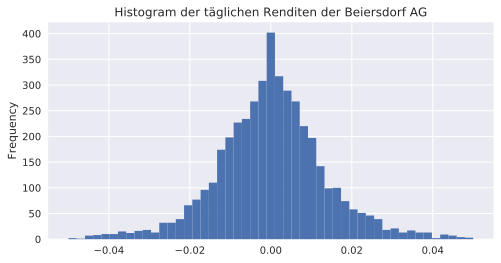

In [8]:
daily_returns["BEI.DE"].plot(
    kind="hist", #  wir legen fest, dass wir ein Histogram (hist) wollen
    figsize=(8, 4), # wir passen die Größe des Charts an
    bins=numpy.linspace(-0.05, 0.05, num=50), # wir legen die Kategorien fest
    title=u"Histogram der täglichen Renditen der Beiersdorf AG" # ...und den Titel
)

Wir können uns außerdem den Verlauf der täglichen Renditen anzeigen lassen. Dazu legen wir <code>kind="line"</code> fest. Pandas kümmert sich automatisch die korrekte Darstellung der Datumswerte.

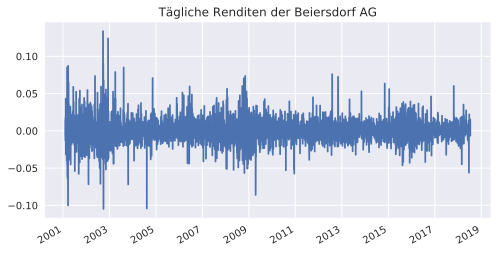

In [9]:
daily_returns["BEI.DE"].plot(
    kind="line",
    figsize=(8, 4),
    title=u"Tägliche Renditen der Beiersdorf AG"
)

Lasst uns noch einen Blick auf die indexierte Wertentwicklung der Aktien werfen. Dazu erstellen wir ein neues DataFrame, addieren alle täglichen Renditen mit 1 und nutzen die <code>cumprod()</code> Funktion um uns zeilenweise das kumulierte Produkt berechnen zu lassen. Letztendlich multiplizieren wir alles mit 100 und erhalten die indexierten Werte:

In [10]:
pandas.options.display.max_rows = 4
print daily_returns.head()
indexed = (daily_returns + 1)
print indexed.head()
indexed = indexed.cumprod()
print indexed.head()
indexed = indexed * 100
print indexed.head()

              DB1.DE    BEI.DE    DPW.DE
2001-02-06  0.041555 -0.005217 -0.000414
2001-02-07 -0.032535  0.013988 -0.009532
...              ...       ...       ...
2001-02-09 -0.024073  0.017466  0.007262
2001-02-12 -0.018667 -0.010300 -0.002120

[5 rows x 3 columns]
              DB1.DE    BEI.DE    DPW.DE
2001-02-06  1.041555  0.994783  0.999586
2001-02-07  0.967465  1.013988  0.990468
...              ...       ...       ...
2001-02-09  0.975927  1.017466  1.007262
2001-02-12  0.981333  0.989700  0.997880

[5 rows x 3 columns]
              DB1.DE    BEI.DE    DPW.DE
2001-02-06  1.041555  0.994783  0.999586
2001-02-07  1.007668  1.008697  0.990058
...              ...       ...       ...
2001-02-09  1.005362  1.013043  0.976802
2001-02-12  0.986595  1.002609  0.974731

[5 rows x 3 columns]
                DB1.DE      BEI.DE     DPW.DE
2001-02-06  104.155493   99.478258  99.958575
2001-02-07  100.766756  100.869729  99.005804
...                ...         ...        ...
2001-02-09  

Das DataFrame <code>indexed</code> können wir nun wie gewohnt zur Visualisierung nutzen:

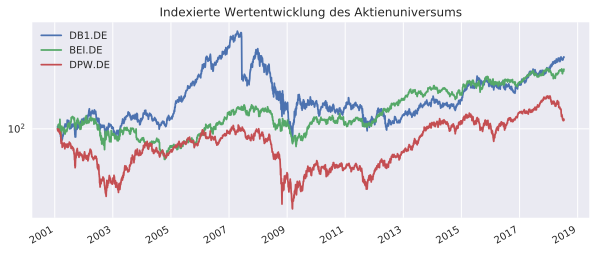

In [11]:
indexed.plot(
    title="Indexierte Wertentwicklung des Aktienuniversums",
    logy=True,
    figsize=(10, 4)
)

Wie bereits erwähnt, gibt uns <code>pandas</code> auch die Möglichkeit schnell und einfach nützliche Statistiken zu den täglichen Renditen zu berechnen. Davon werden wir im nächsten Schritt gebrauch machen, wenn wir die Eigenschaften der Zufallsportfolien berechnen.

In [12]:
print "Mean Values: "
print daily_returns.mean() * 100
print "\nCovariance: "
print daily_returns.cov()
print "\nCorrelation: "
print daily_returns.corr()

Mean Values: 
DB1.DE    0.050443
BEI.DE    0.033418
DPW.DE    0.020312
dtype: float64

Covariance: 
          DB1.DE    BEI.DE    DPW.DE
DB1.DE  0.000463  0.000083  0.000153
BEI.DE  0.000083  0.000240  0.000084
DPW.DE  0.000153  0.000084  0.000337

Correlation: 
          DB1.DE    BEI.DE    DPW.DE
DB1.DE  1.000000  0.250155  0.386898
BEI.DE  0.250155  1.000000  0.294601
DPW.DE  0.386898  0.294601  1.000000


## Zufallsportfolien

Im nächsten Schritt wollen wir verschiedene Zufallsportfolien erstellen. Jedes Portfolio wird alle Wertpapiere enthalten, allerdings wird die Gewichtung immer unterschiedlich sein. Um unseren Aufwand hier zu reduzieren erstellen wir für die Berechnung von zufälligen Portfoliogewichten eine Funktion namens <code>random_weights</code>.

In [13]:
def random_weights(n):
    ''' Berechnet 'n' zufällige Portfoliogewichte, welche in
        Summe 100% ergeben.
    '''
    # n Zufallszahlen zwischen 0 und 1
    random_numbers = numpy.random.rand(n) 
    # teile die Array-Werte durch ihre Summe
    # sodass die Summe immer 1 ergibt
    random_weights = random_numbers / sum(random_numbers)

    return random_weights

Dadurch, dass wir die $n$ Zufallszahlen durch ihre entsprechende Summe teilen, sind sie automatisch normiert und ergeben in Summe $1$:

In [14]:
print random_weights(2), sum(random_weights(2))
print random_weights(3), sum(random_weights(3)
print random_weights(4), sum(random_weights(4))

[0.27351376 0.40974791 0.31673833] 1.0
[0.0019514  0.24558361 0.20066262 0.02835843 0.20788636 0.31555758] 1.0


Nun benötigen wir noch eine Funktion, welche uns die mittlere Rendite und die Standardabweichung eines zufälligen Portfolios berechnet. Hierbei erleichtert uns <code>numpy</code> die Arbeit. Mittel <code>numpy.asmatrix</code> wandeln wir einzelne Arrays in Matrizen um und können sie anschließend mit <code>numpy.dot</code> multiplizieren. (Genau genommen könnte man diese Funktion auch kürzer schreiben, aber zur besseren Verständlichkeit habe ich diese Funktion bewusst etwas ausführlicher belassen) 

Numpy übernimmt für uns die Berechnung der Varianz-Kovarianz Matrix und die Kalkulationen mit Vektoren und Matrizen:

In [15]:
def random_portfolio(returns):
    ''' Calculates the expected return and the vola of a random portfolio
    using the pandas dataframe returns.'''
    
    if type(returns) != type(pandas.DataFrame()):
        raise TypeError, "Variable 'returns' musst be a pandas DataFrame."

    # wie viele Wertpapiere liegen uns vor?
    n_assets = len(returns.columns)
    
    # Lasse zufällige Portfoliogewichte erstellen und transformiere
    # das Ergebnis in eine Matrix (1 x m)
    weight_matrix = numpy.asmatrix(random_weights(n_assets))
    
    # Berechne den Mittelwert der einzelnen Wertpapier-Renditen
    # und erstelle daraus eine Matrix (1 x m)
    return_matrix = numpy.asmatrix(returns.mean())
    # transformiere von (1 x m) zu (m x 1)
    return_matrix = return_matrix.T
    
    # Berechne die Varianz-Kovarianz Matrix der Wertpapier-Renditen
    covar_matrix = returns.cov()
    
    # Berechne die erw. Rendite
    mu = numpy.dot(weight_matrix, return_matrix)
    # Berechne die Portfolio-Vola (sigma)
    variance = numpy.dot(numpy.dot(weight_matrix, covar_matrix), weight_matrix.T)
    sigma = numpy.sqrt(variance)

    # Gebe die hist. Rendite und die Vola zurück
    return numpy.asscalar(mu), numpy.asscalar(sigma)

Lasst uns die Werte von zwei, drei Zufallsportfolien prüfen:

In [16]:
print random_portfolio(daily_returns)
print random_portfolio(daily_returns)
print random_portfolio(daily_returns)

(0.00038529217675145356, 0.013710621321623108)
(0.00031427448394535137, 0.013102818092082958)
(0.0002787631835710735, 0.014415177496936615)


## Visualisierung

Da die Berechnung von Zufallsportfolien funktioniert, kommen wir nun zum finalen Schritt. Wir fügen nun alle "Puzzle-Teile" zusammen. 

Wir lassen uns jetzt $n_{portfolios}$ zufällige Portfolios generieren. Für jedes Portfolio berechnen wir die erwartete Rendite und die Vola und fügen sie zu zwei separate Listen hinzu.

In [17]:
%%time
# durch das Magic command %%time messen wir
# den Zeitverbrauch der folgenden Anweisung

# erstelle listen für die erw. Renditen
# und die historischen Volas der Zufalls-
# portfolien
means = []
stds = []

# wir wollen 2000 Zufallsportfolien simulieren
n_portfolios = 1000

# für n_portfolios
for n in range(n_portfolios):
    # berechne die Eigenschaften eines Zufallsportfolios
    mean, std = random_portfolio(daily_returns)

    # ...und füge diese zu den Listen means und stds hinzu
    means.append(mean)
    stds.append(std)

CPU times: user 1.35 s, sys: 8.13 ms, total: 1.36 s
Wall time: 1.36 s


Schließlich lassen wir uns jedes Portfolio in einem XY-Chart anzeigen, wobei die Y-Achse die Volas anzeigt und die X-Achse die erwartete Rendite. Jeder blaue Punkt steht für ein Zufallsportfolio.

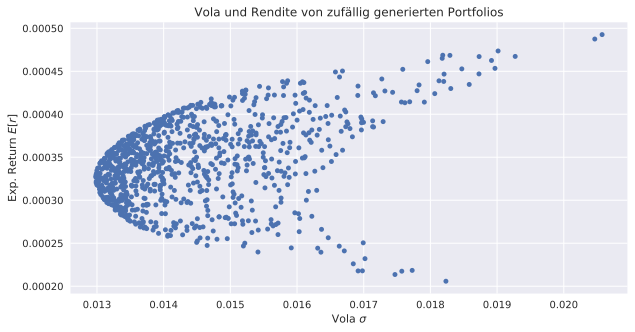

In [18]:
# wir sagen matplotlib, dass wir ein Chart erstellen (figure)
# und legen die Groesse auf (10, 5) fest
plt.figure(figsize=(10,5))

# Visualisiere den Zusammenhang von means und stds
plt.plot(stds, means, 'o', markersize=5)
plt.xlabel('Vola $\sigma$')
plt.ylabel('Exp. Return $E[r]$')
plt.title(u'Vola und Rendite von zufällig generierten Portfolios')
plt.savefig("efficient_frontier_model_introduction.png")

<div style="float:right;clear:right;">
<img src="http://hello-finance.io/wp-content/uploads/2018/01/markowitz-1024x384.png" width="400px" />
</div>
<p>Wie wir sehen können ergibt sich der von Markowitz beschriebene Zusammenhang sehr deutlich. Die Portfolien folgen der von Markowitz beschriebenen Efficient Frontier. Anhand unserer Daten können wir bestätigen, dass es in der Vergangenheit effiziente und ebenfalls ineffiziente Portfolien gab. Wir können außerdem erkennen, dass es einen positiven Zusammenhang zwischen Volatilität und erwarteter Rendite zu geben scheint.</p>
<p>Im nächsten Teil der Beitragsserie werden wir uns mit Optimierungsverfahren beschäftigen um anhand echter Kursdaten ein Minimum-Varianz- und ein Tangency-Portfolio zu berechnen.</p>

## Lizenz

<div style="border:1px dotted;padding:10px;">
<h4>The MIT License (MIT)</h4>

<tiny>
    <p>Copyright © 2018 Jan-Christopher Magel</p>

<p>Permission is hereby granted, free of charge, to any person
obtaining a copy of this software and associated documentation
files (the “Software”), to deal in the Software without
restriction, including without limitation the rights to use,
copy, modify, merge, publish, distribute, sublicense, and/or sell
copies of the Software, and to permit persons to whom the
Software is furnished to do so, subject to the following
conditions:</p>

<p>The above copyright notice and this permission notice shall be
included in all copies or substantial portions of the Software.</p>

<p>THE SOFTWARE IS PROVIDED “AS IS”, WITHOUT WARRANTY OF ANY KIND,
EXPRESS OR IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES
OF MERCHANTABILITY, FITNESS FOR A PARTICULAR PURPOSE AND
NONINFRINGEMENT. IN NO EVENT SHALL THE AUTHORS OR COPYRIGHT
HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER LIABILITY,
WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING
FROM, OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR
OTHER DEALINGS IN THE SOFTWARE.
    </p>
</tiny>
</div>